In [11]:
import gdown
import pandas as pd

# Set the display options to ensure all rows and columns are displayed.
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

# Define the Mamdani Fuzzy Inference System class
class Mamdani_FIS:
    def __init__(self, num_MF_input=13, num_MF_output=23, max_velocity=120, max_distance=1000, max_pedal=45):
        self.num_MF_input = num_MF_input
        self.num_MF_output = num_MF_output
        self.max_velocity = max_velocity
        self.max_distance = max_distance
        self.max_pedal = max_pedal
        self.data = self.get_data()

    def get_data(self):
        # Use gdown to download the dataset from Google Drive
        url = 'https://drive.google.com/uc?id=1dlvS7Kb-0pYXP3_719yulbF6JG8PtU57'
        file_path = 'Updated_Fuzzy_Rules.xlsx'
        gdown.download(url, file_path, quiet=False)
        data = pd.read_excel(file_path)
        return data

    def get_parameters_MFs(self, num_MFs, max_value):
        # Calculate parameters for the membership functions based on the given range and number of MFs
        step = max_value / (num_MFs - 1)
        parameters_MFs = []
        for i in range(num_MFs):
            if i == 0:
                index = [0, 0, step]
            elif i == num_MFs - 1:
                index = [(i-1) * step, i * step, i * step]
            else:
                index = [(i-1) * step, i * step, (i+1) * step]
            parameters_MFs.append(index)
        return parameters_MFs

    def triangular(self, x, params):
        # Calculate the degree of membership for a value x using a triangular shape
        a, b, c = params
        if a <= x <= b:
            return (x - a) / (b - a)
        elif b < x <= c:
            return (c - x) / (c - b)
        return 0.0

    def process_inputs(self, velocity, distance):
        # Process input values through their respective membership functions
        params_velocity = self.get_parameters_MFs(self.num_MF_input, self.max_velocity)
        params_distance = self.get_parameters_MFs(self.num_MF_input, self.max_distance)
        MF_values_velocity = [self.triangular(velocity, params) for params in params_velocity]
        MF_values_distance = [self.triangular(distance, params) for params in params_distance]
        return MF_values_velocity, MF_values_distance

    def apply_rules(self, MF_velocity, MF_distance):
        # Apply the fuzzy rules to determine the degree of membership for each rule's output
        self.data['MF_Vel'] = [MF_velocity[int(i)-1] for i in self.data['Velocity Index']]
        self.data['MF_Dis'] = [MF_distance[int(i)-1] for i in self.data['Distance Index']]
        self.data['Product'] = self.data.apply(lambda row: min(row['MF_Vel'], row['MF_Dis']), axis=1)

    def compute_output(self, velocity, distance):
        # Compute the final output by aggregating the contributions from all the rules
        MF_velocity, MF_distance = self.process_inputs(velocity, distance)
        self.apply_rules(MF_velocity, MF_distance)
        self.update_center_values()
        self.data['Center_Pedal'] = self.data['Center']
        weighted_sum = (self.data['Product'] * self.data['Center']).sum()
        weights_sum = self.data['Product'].sum()
        if weights_sum == 0:
            return 0
        return weighted_sum / weights_sum

    def update_center_values(self):
        # Update the center values for the output membership functions
        params_pedal = self.get_parameters_MFs(self.num_MF_output, self.max_pedal)
        centers = [((params[1] + params[2]) / 2 if i != self.num_MF_output - 1 else params[1]) for i, params in enumerate(params_pedal)]
        self.data['Center'] = [centers[int(i)-1] for i in self.data['Pedal Index']]

# Create an instance of the Mamdani_FIS class
fis = Mamdani_FIS()

# Compute the output for a given pair of velocity and distance
output = fis.compute_output(60, 500)
print("Output pedal position:", output)

# Generate the styled DataFrame
styled_df = fis.data.style.applymap(lambda x: 'color: black', subset=['Velocity Index', 'Distance Index', 'Pedal Index']) \
                          .background_gradient(subset=['MF_Vel', 'MF_Dis', 'Product', 'Center'], cmap='viridis') \
                          .set_properties(**{'text-align': 'center'}) \
                          .set_table_styles([dict(selector='th', props=[('text-align', 'center')])]) \
                          .hide_index() \
                          .format(precision=4)

# Show the styled DataFrame
styled_df


Downloading...
From: https://drive.google.com/uc?id=1dlvS7Kb-0pYXP3_719yulbF6JG8PtU57
To: /content/Updated_Fuzzy_Rules.xlsx
100%|██████████| 7.75k/7.75k [00:00<00:00, 9.26MB/s]


Output pedal position: 31.704545454545453


<ipython-input-11-8aad2850c2b1>:95: FutureWarning: this method is deprecated in favour of `Styler.hide(axis="index")`
  .hide_index() \


Velocity Index,Distance Index,Pedal Index,MF_Vel,MF_Dis,Product,Center,Center_Pedal
1,1,1,0.0000,0.0000,0.0000,1.0227,1.0227
1,2,2,0.0000,0.0000,0.0000,3.0682,3.0682
1,3,3,0.0000,0.0000,0.0000,5.1136,5.1136
1,4,4,0.0000,0.0000,0.0000,7.1591,7.1591
1,5,5,0.0000,0.0000,0.0000,9.2045,9.2045
1,6,6,0.0000,0.0000,0.0000,11.2500,11.2500
1,7,7,0.0000,1.0000,0.0000,13.2955,13.2955
1,8,8,0.0000,0.0000,0.0000,15.3409,15.3409
1,9,9,0.0000,0.0000,0.0000,17.3864,17.3864
1,10,10,0.0000,0.0000,0.0000,19.4318,19.4318


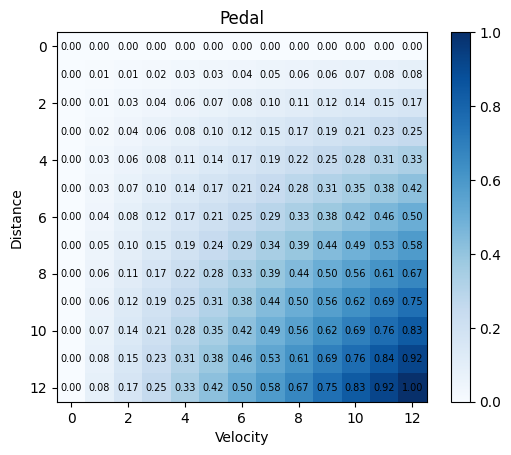

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

num = 13  # Increased number of samples

# Generate velocity and distance samples
sampleVelocity = np.linspace(0, 1, num)
sampleDistance = np.linspace(0, 1, num)

# Generate random matrix with new dimensions
matrix = np.random.rand(num, num)

# Function that simulates the output for given velocity and distance
# Assuming there is a function called `fis.get_output` as hinted in the original code
# You would need to define or import this function as required by your application
def get_output(velocity, distance):
    # Placeholder function, you should replace it with the actual logic or function call
    return velocity * distance

# Update matrix values using the output function
for i in range(num):
    for j in range(num):
        matrix[i, j] = get_output(sampleVelocity[i], sampleDistance[j])

# Define maximum value for better color scaling
max_value = np.max(matrix)

# Create a new figure and axis
fig, ax = plt.subplots()

# Create a heatmap
heatmap = ax.imshow(matrix, cmap='Blues')

# Add color bar
cbar = plt.colorbar(heatmap)

# Iterate over each cell to annotate the value
for i in range(num):
    for j in range(num):
        ax.text(j, i, f'{matrix[i, j]:.2f}', ha='center', va='center', color='black', fontsize=7)

# Set plot titles and labels
plt.title('Pedal')
plt.xlabel('Velocity')
plt.ylabel('Distance')

# Show plot
plt.show()
